In [1]:
import torch
import sys
sys.path.append('../')
import time
from robust_tt import RTT 
from dyn_models.pushing_dyn_general_mm import pusher_slider_sys
torch.set_default_dtype(torch.float64)
from tt_utils import contract_sites
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
w = 0.5
state_max = torch.tensor([w,w,torch.pi, torch.pi, 0.05]).to(device) # (s_x, s_y, s_theta, psi, phi) 
state_min =  torch.tensor([-w,-w,-torch.pi, -torch.pi, 0]).to(device)

param_max = torch.tensor([0.15, 1.5, 0.8]).to(device) #(r, mass, u_gs)
param_min = torch.tensor([0.06, 0.5, 0.2]).to(device) #(r, mass, u_gs)

# n = 100
n_state = 50
n_param = 100
n_action = 50
n_action = [n_action]*4


v_max = 0.1
f_max = 3

u_ps = 1.0

action_max = torch.tensor([f_max, u_ps*f_max, torch.pi, 0.05]).to(device) # (fc_n, fc_t, psi_next, phi_next)
action_min = torch.tensor([0, -u_ps*f_max, -torch.pi, 0]).to(device) 

In [4]:
p_target = torch.tensor([0., 0., 0.]).view(1,-1).to(device)
dt= 0.1
T=50

dyn_system =  pusher_slider_sys(p_target=p_target,dt=dt, device=device)

In [5]:
domain_state = [torch.linspace(state_min[i],state_max[i],n_state).to(device) for i in range(len(state_max))]
domain_param = [torch.linspace(param_min[i],param_max[i],n_param).to(device) for i in range(len(param_max))]
domain_action =[torch.linspace(action_min[i],action_max[i],n_action[i]).to(device) for i in range(len(action_max))]
domain_state_param = domain_state + domain_param

In [6]:
def forward_model(state_param,action):
    next_state = dyn_system.dynamics(state_param,action)
    return next_state


def reward(state_param,action):
    rewards = -1*dyn_system.cost_func(state_param,action,scale=w)
    return rewards

In [7]:
n_test = 100
dim_state = len(domain_state)
init_state = torch.empty((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).clip(0.25,0.75).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)


In [8]:
rtt = RTT(domain_state=domain_state+domain_param, domain_param=domain_param,
                domain_action=domain_action, 
                reward=reward, 
                normalize_reward=False,
                forward_model=forward_model, 
                gamma=0.99, dt=dt,
                rmax_v=100, rmax_a=100, 
                nswp_v=5, nswp_a=5, 
                kickrank_v=10, kickrank_a=20,
                max_batch_v=10**4,max_batch_a=10**5,
                eps_cross_v=1e-3,
                eps_cross_a=1e-3,
                eps_round_v=1e-4, 
                eps_round_a=1e-3, 
                n_samples=10, 
                verbose=True,
                device=device) # action = 'deterministic_tt', 'stochastic_tt', 'random'

In [9]:
model = torch.load('tt_models/pushing.pt')
rtt.reward_tt = model['reward_tt'].to(rtt.device)
rtt.reward_max = rtt.get_max_a(rtt.reward_tt)[0]
if not rtt.normalize_reward:
    rtt.reward_max = 1.0
else:
    rtt.reward_max = torch.abs(rtt.get_max_a(rtt.reward_tt)[0])
rtt.reward_normalized_tt = rtt.reward_tt*(1/rtt.reward_max)
rtt.reward_normalized_tt.round(1e-9)
rtt.reward_normalized_tt = rtt.reward_normalized_tt.to(rtt.device)  
rtt.v_model = model['v_model'].to(rtt.device)
rtt.a_model = rtt.compute_advantage_model_from_value().to(rtt.device)
rtt.policy_model = rtt.normalize_tt_a(rtt.a_model.clone())
rtt.policy_model_cores = rtt.policy_model.tt().cores[:]


.....................................................
Computing Advantage Fcn
.....................................................
cross device is cuda
Cross-approximation over a 12D domain containing 1.95312e+21 grid points:
iter: 0 | eps: 1.366e-01 | time:   0.2017 | largest rank:   1
iter: 1 | eps: 1.091e-02 | time:   2.5042 | largest rank:  21
iter: 2 | eps: 1.018e-02 | time:   6.3767 | largest rank:  41
iter: 3 | eps: 7.597e-03 | time:  12.7295 | largest rank:  61
iter: 4 

| eps: 6.059e-03 | time:  24.0623 | largest rank:  81 <- max_iter was reached: 5
Did 15514550 function evaluations, which took 15.19s (1.021e+06 evals/s)



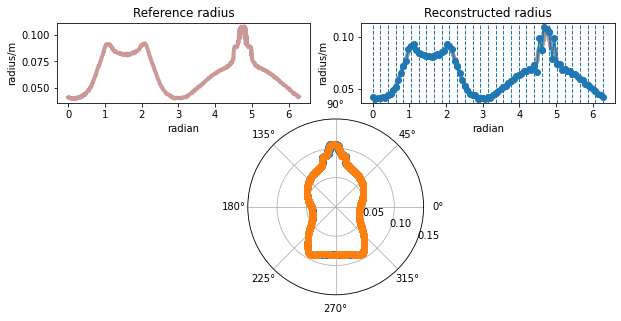

In [10]:
from shape_parametrization import BasisFunctions
data = np.load(sys.path[0]+"/meshes/mustared_points.npy", allow_pickle="True")
BF_ys = BasisFunctions(nbFct=4, nbSeg=20, nbIn=1, nbOut=1, nbDim=4*20*10, data=data)

# compute weights
t = np.linspace(0, 1 - 1 / BF_ys.nbDim, BF_ys.nbDim)
BF_ys.compute_w(data, t)

def compute_radius(theta):
    #theta here is from 0 to 2*pi
    t = (theta+np.pi)/(2*np.pi)
    Psi, dPsi, phi = BF_ys.computePsiList1D(t)
    x_b = Psi @ BF_ys.w_b
    return x_b


In [11]:
tol = torch.tensor([0.03, 0.03, 15/180*torch.pi]).to(device)[:3]
slider_r = 0.01

def contract_callback(rtt, state, contract_policy_model, real_param, sim_param, animation=False, file_name='file', callback_count=0):
    # print("Testing....")
    
    history = []
    # param  = torch.tensor([1.,1., 0.5]).view(1,-1).expand(state.shape[0],-1).to(device)
    traj = state[:,:].clone()[:,None,:] #bsx(T+1)x6
    traj_actions = torch.empty(state.shape[0],T,4).to(device) #bsxTx3
    print("T", T)
    cum_reward = torch.tensor([0.]*state.shape[0]).to(device)
    real_state_param = torch.cat((state,real_param),dim=-1)
    sim_state_param = torch.cat((state,sim_param),dim=-1)   
    dt_cum = 0
    num = 1
    real_state = state[:,:5].clone()
    for i in range(T):
        # state = real_state_param[:,:5]
        state = sim_state_param[:,:5]
        real_state = real_state_param[:,:5]
        t0 = time.time()
        psi = state[:, 3].cpu().numpy()
        radius = torch.tensor(compute_radius(psi)).to(device)
        phi = state[:, 4].cpu().numpy()
        sim_param = torch.cat((radius[:,None], sim_param[:,1:]), dim=-1)
        real_param = torch.cat((radius[:,None], real_param[:,1:]), dim=-1)

        real_state_param = torch.cat((real_state,real_param),dim=-1)
        sim_state_param = torch.cat((state,sim_param),dim=-1)

        action = rtt.policy_ttgo_contract(state, contract_policy_model, device)
        t1=time.time()
        dt_cum+=(t1-t0)
        r = reward(real_state_param,action)
        cum_reward+=r#reward_test(state,action)
        real_state_param = forward_model(real_state_param,action)

        sim_state_param = forward_model(sim_state_param,action)
        p_x = [phi+compute_radius(psi)+slider_r]*np.cos(psi)
        p_y = [phi+compute_radius(psi)+slider_r]*np.sin(psi)
        p_x = torch.tensor(p_x[0]).to(device)
        p_y = torch.tensor(p_y[0]).to(device)
        traj = torch.concat((traj, torch.cat((real_state[:,None,:3], p_x[:, None, None], p_y[:, None, None]), dim=-1)),dim=1)
        traj_actions[:,i,:]=action
    final_state = traj[:,-1,:]
    final_err = torch.mean(torch.norm(final_state[:,:3],dim=1))
    print(f"Average of final error is {final_err.mean()}")
    from plot_utils import plot_planarpush_general

    plot_num = 1 # number of plotted tasks
    plt=plot_planarpush_general(traj[-plot_num:].to('cpu').numpy(),
                        traj_actions[-plot_num:].to('cpu').numpy(), 
                        animation=animation, step_skip=1, 
                        xmax=w,x_target=p_target[0].to('cpu').numpy(),figsize=6, data=data,
                        save_as=None, file_name=file_name,
                        scale=10)
    plt.show()        

T 50
Success rate of 100 tests is 99.0%
Average of final error is 0.0315792727539558



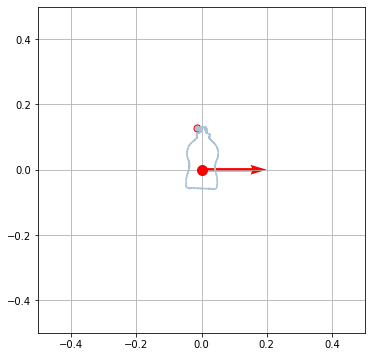

In [12]:
site_x = [5, 6, 7] #[radius, mass, u_gs]
num_para = len(site_x)    

# state initialization
init_state = torch.empty((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).clip(0.25,0.75).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)


#param initialization
mean_id = torch.randint(0, n_param-1, (num_para,)).to(device)
real_param = torch.zeros(num_para).to(device)
for i in range(num_para):
    real_param[i] = domain_param[i][mean_id[i]]
real_param = real_param.view(1, -1).expand(n_test, -1).to(device)

# get parameter-conditioned advantage function through domain contraction
rtt.domain_state_action = domain_state + domain_action # the previous domain_state_action is domain_state + domain_param + domain_action
contract_policy_model = rtt.get_contract_policy(site_x=site_x, mean_id=mean_id, sigma=n_param, length=1/5*n_param, flag = 'uniform', device=device)

contract_callback(rtt, state, contract_policy_model, real_param, real_param, animation=False)